In [1]:
import proplot as pplt
import matplotlib as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

from shapely import wkt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
import rasterio.mask as rmask
from shapely import Polygon

In [2]:
arnot_forest = rio.open('./Data/Logging/arnot_logging_mask_2020.tif')

In [3]:
arnot_forest.read()

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [37]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs, mask_polygon=None):
    if mask_polygon is not None:
        orig_image, orig_transform = rmask.mask(raster_file, [mask_polygon], crop=True)
    else:
        orig_image = raster_file.read()
        orig_transform = raster_file.transform
        
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=orig_image,
        src_transform=orig_transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=0)
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    #new_image = np.concatenate([new_image, new_image, new_image])
    #new_image = new_image.transpose([1, 2, 0])
    new_image = np.clip(new_image / np.nanpercentile(new_image, 95), 0, 1)
    
    # Create a nan mask
    #alpha_channel = ~np.isnan(new_image[:, :, [0]])
    #new_image = np.concatenate([new_image, alpha_channel], axis=2)

    return new_image, new_bounds

arnot_forest_reproj, arnot_forest_reproj_bounds = prepare_for_viz(arnot_forest, dest_crs)

C:\Users\camer\AppData\Local\Temp\ipykernel_24228\2042830568.py:24: RuntimeWarning: divide by zero encountered in divide
  new_image = np.clip(new_image / np.nanpercentile(new_image, 95), 0, 1)
C:\Users\camer\AppData\Local\Temp\ipykernel_24228\2042830568.py:24: RuntimeWarning: invalid value encountered in divide
  new_image = np.clip(new_image / np.nanpercentile(new_image, 95), 0, 1)


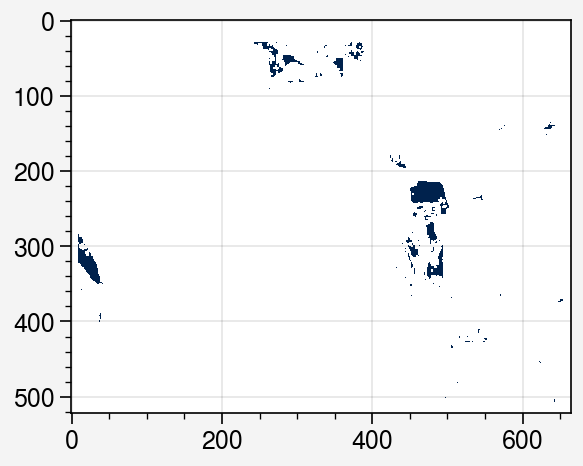

In [38]:
fig, ax = pplt.subplots()

ax.imshow(arnot_forest_reproj[0], cmap='cividis')

In [36]:
np.any(arnot_forest_reproj == 0)

False

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


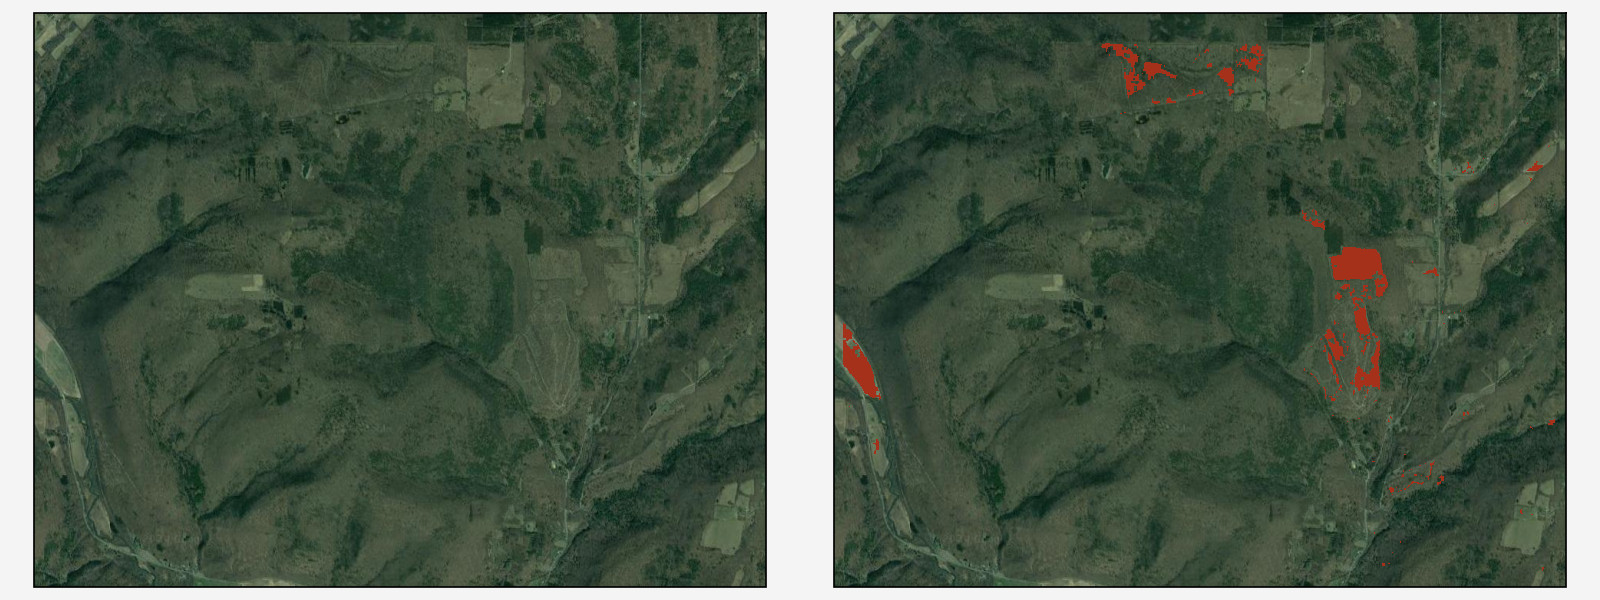

In [47]:
fig, axes = pplt.subplots(ncols=2, proj=dest_crs, figsize=(8, 3))

background = cimgt.GoogleTiles(style='satellite')
axes[0].add_image(background, 14)
axes[0].set_extent([arnot_forest_reproj_bounds[0], arnot_forest_reproj_bounds[2], arnot_forest_reproj_bounds[1], arnot_forest_reproj_bounds[3]], crs=dest_crs)

axes[1].add_image(background, 14)
axes[1].imshow(arnot_forest_reproj[0], cmap='Oranges3_r',
                 extent=[arnot_forest_reproj_bounds[0], arnot_forest_reproj_bounds[2], arnot_forest_reproj_bounds[1], arnot_forest_reproj_bounds[3]], 
                 origin='upper', transform=dest_crs, zorder=10)
axes[1].set_extent([arnot_forest_reproj_bounds[0], arnot_forest_reproj_bounds[2], arnot_forest_reproj_bounds[1], arnot_forest_reproj_bounds[3]], crs=dest_crs)

fig.savefig('./Figures/Logging/arnot_logging_qa_mask_2020.png')

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


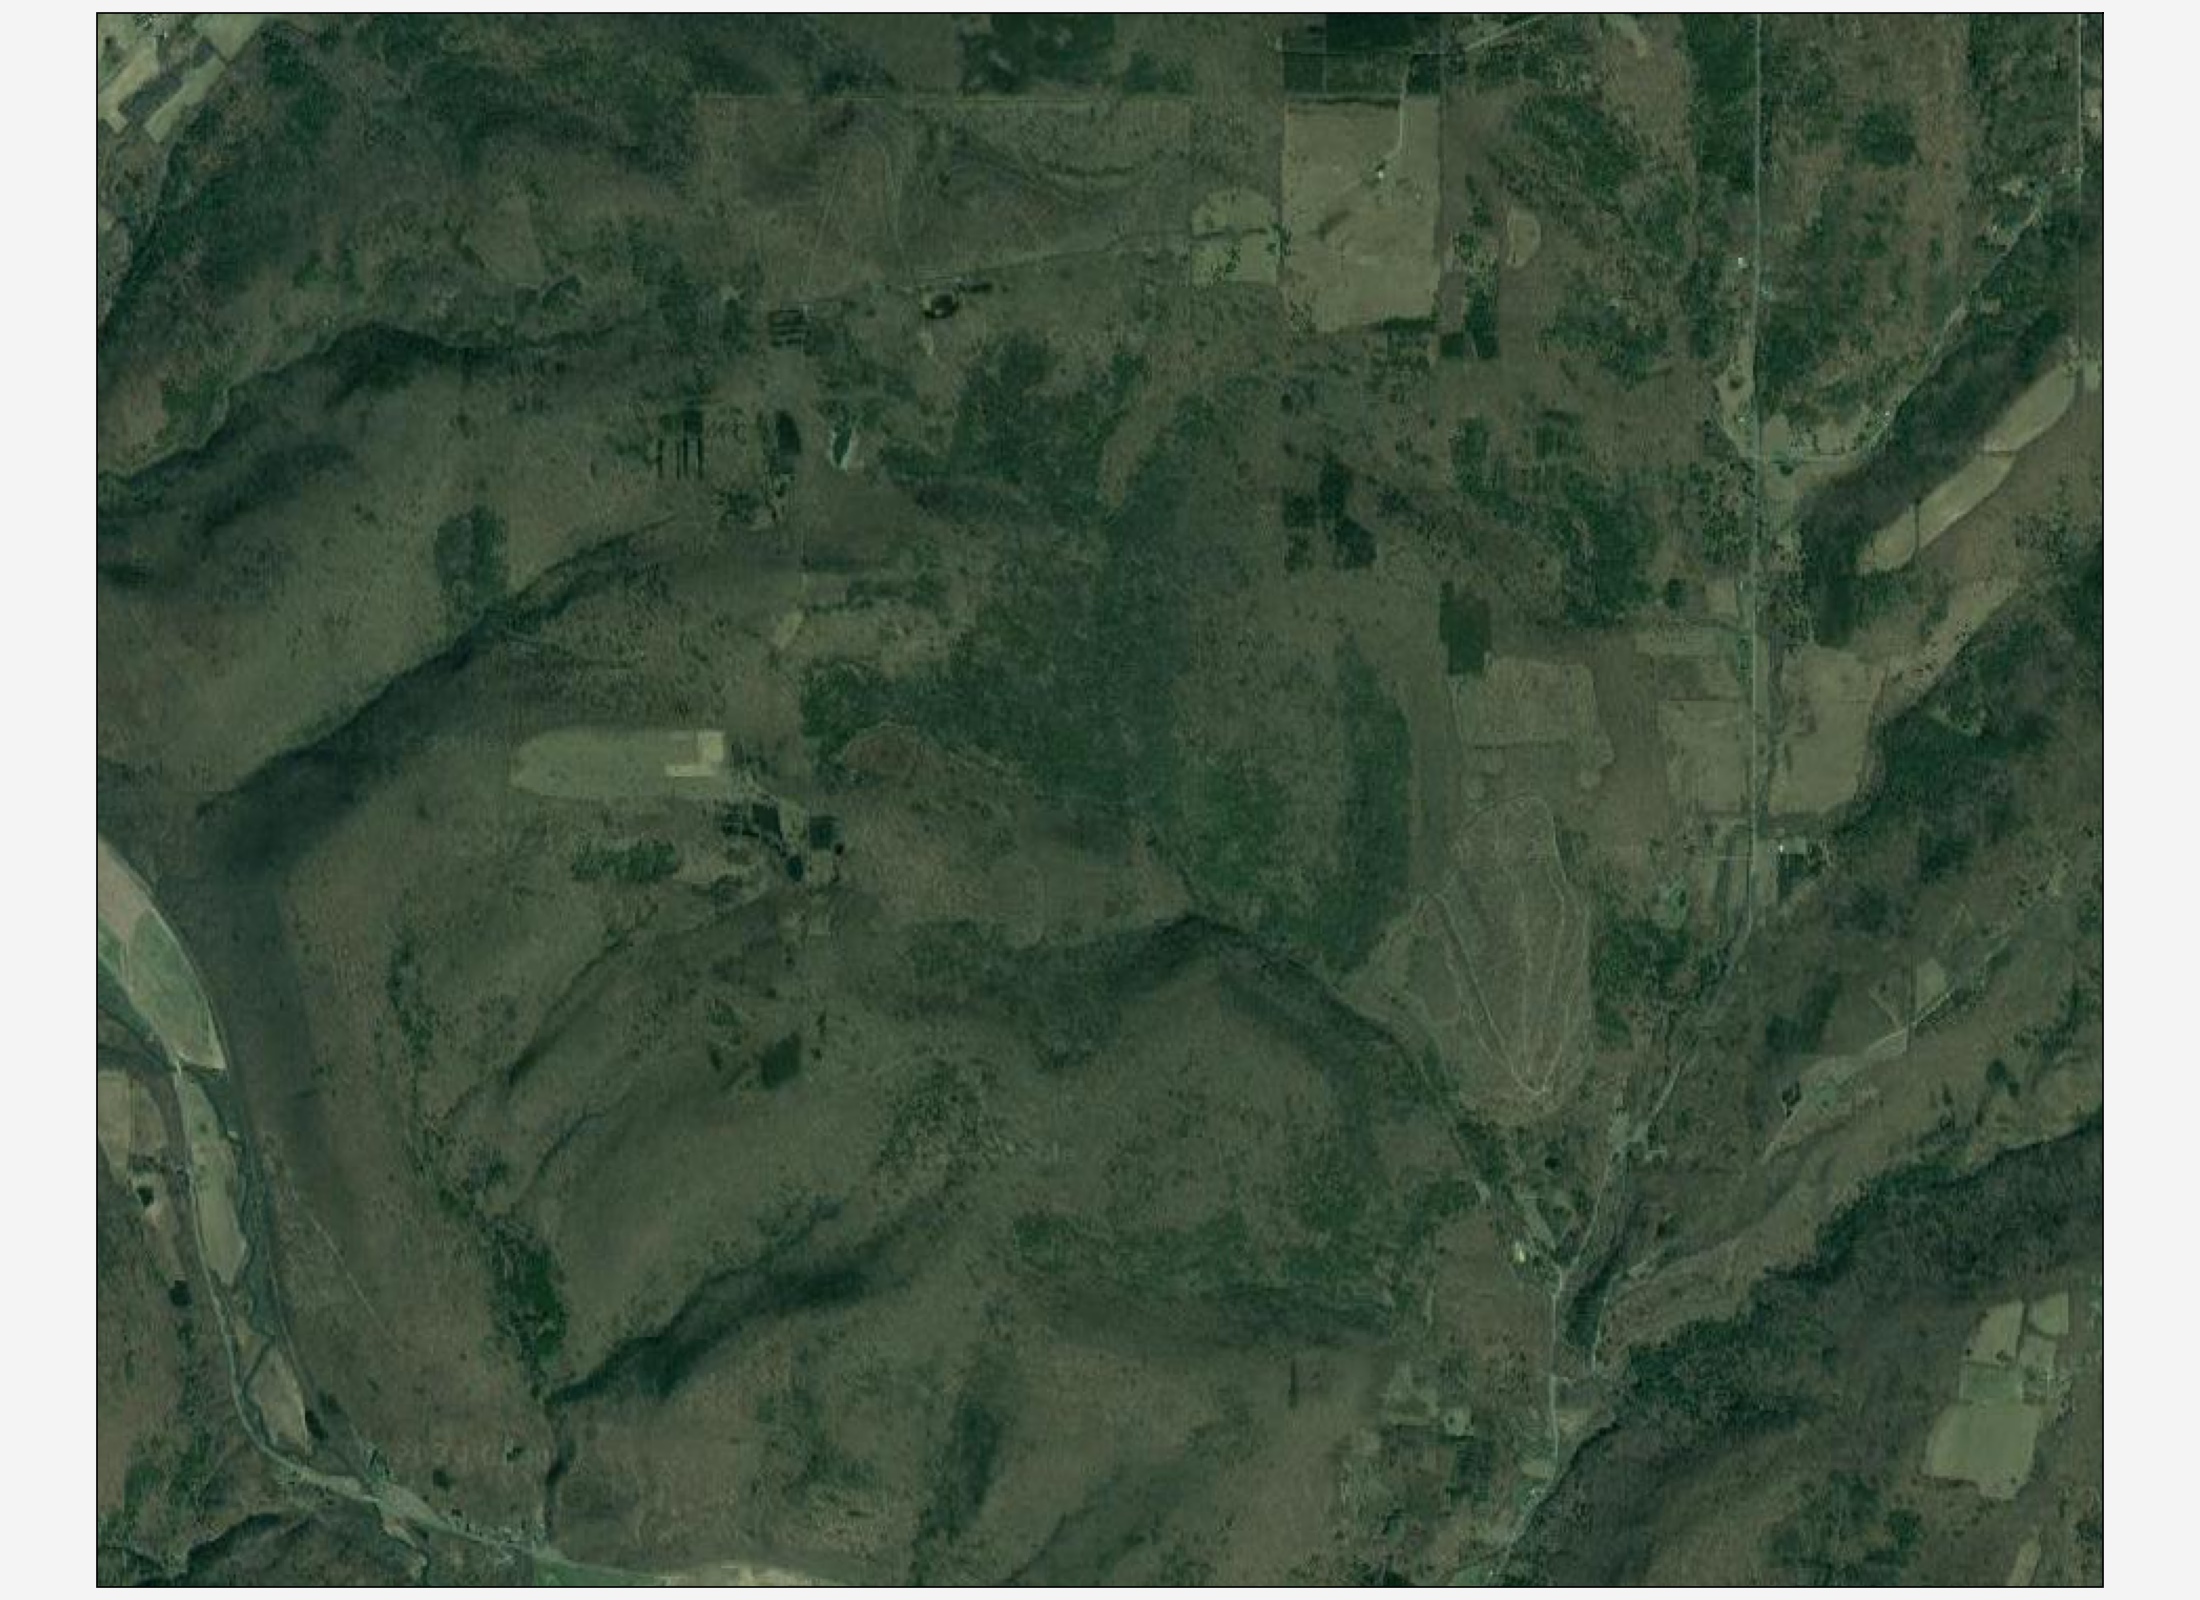

In [23]:
fig, ax = pplt.subplots(proj=dest_crs, figsize=(11, 8))

background = cimgt.GoogleTiles(style='satellite')
ax.add_image(background, 14)
ax.set_extent([arnot_forest_reproj_bounds[0], arnot_forest_reproj_bounds[2], arnot_forest_reproj_bounds[1], arnot_forest_reproj_bounds[3]], crs=dest_crs)